# Special Case: Inference with FGC

In this tutorial we want to show how we can use FGC to do inference on unseen data. When training a Random Forest model, we often divide the data into a training and test set because we are interested in understanding how well the Random Forest model generalizes to new data. This generalization is often only measured with performance metrics, however FGC also allows us to see how well the concluded explanations generalize to new unseen data. 

**Note:** for installation description and a general introduction to FGC please have a look at [Read the Docs - Installation](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html) and [Introduction Notebook](https://github.com/HelmholtzAI-Consultants-Munich/fg-clustering/blob/main/tutorials/introduction_to_FGC_use_cases.ipynb).

**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import FgClustering

## Imports for datasets
from sklearn.datasets import fetch_california_housing

## Additional imports for use-cases

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

To showcase how FGC can be used during inference time, we will again use the California Housing dataset (for dataset description, please see *Use Case 3*). We will use the first 1000 samples of the dataset as training data to train a Random Forest Regressor, where we tuned the *max_depth* and *max_features* parameters with 5-fold corss-validation.

In [2]:
data_housing = fetch_california_housing(as_frame=True).frame

data_housing_train = data_housing.iloc[:1000]
X_housing_train = data_housing_train.loc[:, data_housing_train.columns != 'MedHouseVal']
y_housing_train = data_housing_train.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing_train, y_housing_train)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'Train Set R^2 of prediction model: {round(rf_housing.score(X_housing_train, y_housing_train),3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
Train Set R^2 of prediction model: 0.826


To understand the relation between housing values and the provided features (e.g. median income, house age etc.), we apply the Forest-Guided Clustering method on the training dataset and the trained Random Forest model.

Interpreting RandomForestRegressor
Optimal number of cluster is: 4


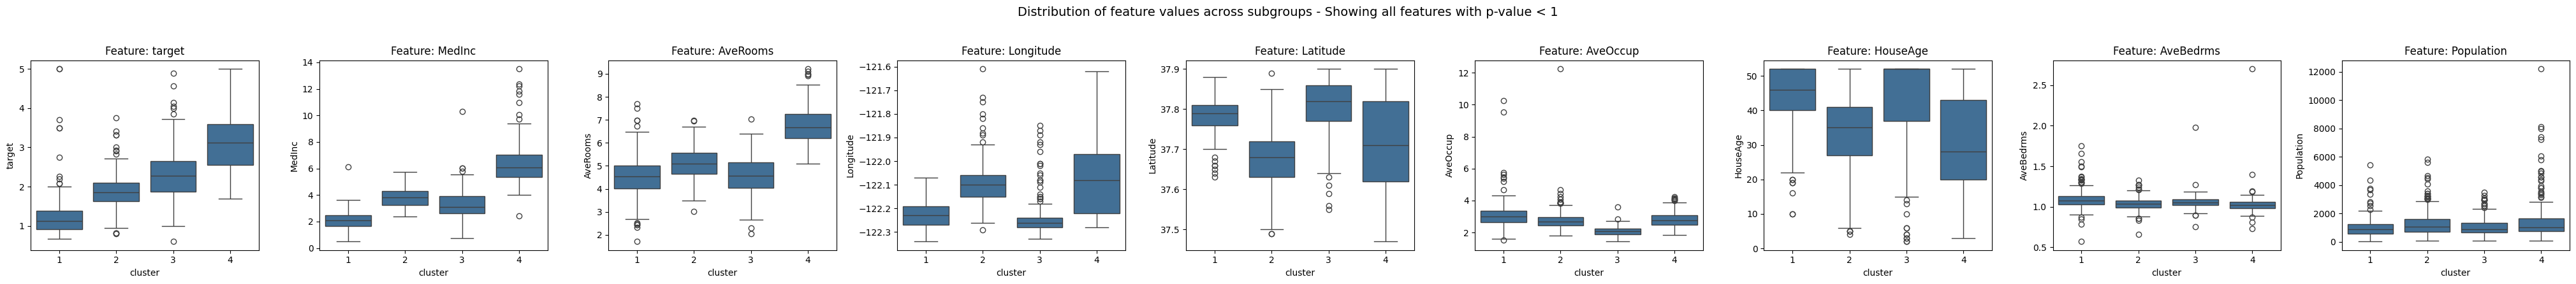

In [3]:
fgc = FgClustering(model=rf_housing, data=data_housing_train, target_column='MedHouseVal')
fgc.run(discart_value_JI = 0.75, verbose=0)

fgc.plot_decision_paths(heatmap=False, num_cols = 9) 

Next, we will use the another 1000 samples of the California Housing dataset as test data and calculate the performance of the Random Forest on the test set.

In [4]:
data_housing_test = data_housing.iloc[6000:7000]
data_housing_test.reset_index(inplace=True, drop=True)
X_housing_test = data_housing_test.loc[:, data_housing_test.columns != 'MedHouseVal']
y_housing_test = data_housing_test.MedHouseVal

print(f'Test Set R^2 of prediction model: {round(rf_housing.score(X_housing_test, y_housing_test),3)}')

Test Set R^2 of prediction model: 0.562


As we can see above, the performance on the test set decreased compared to the training set. Hence, we are interested to know, which relations between the housing value and the provided features, that we identified using the training set, still hold and which don't. Therefore, we run FGC on the Random Forest model (trained on the training data) and the test data.

Interpreting RandomForestRegressor
Use 4 as number of cluster


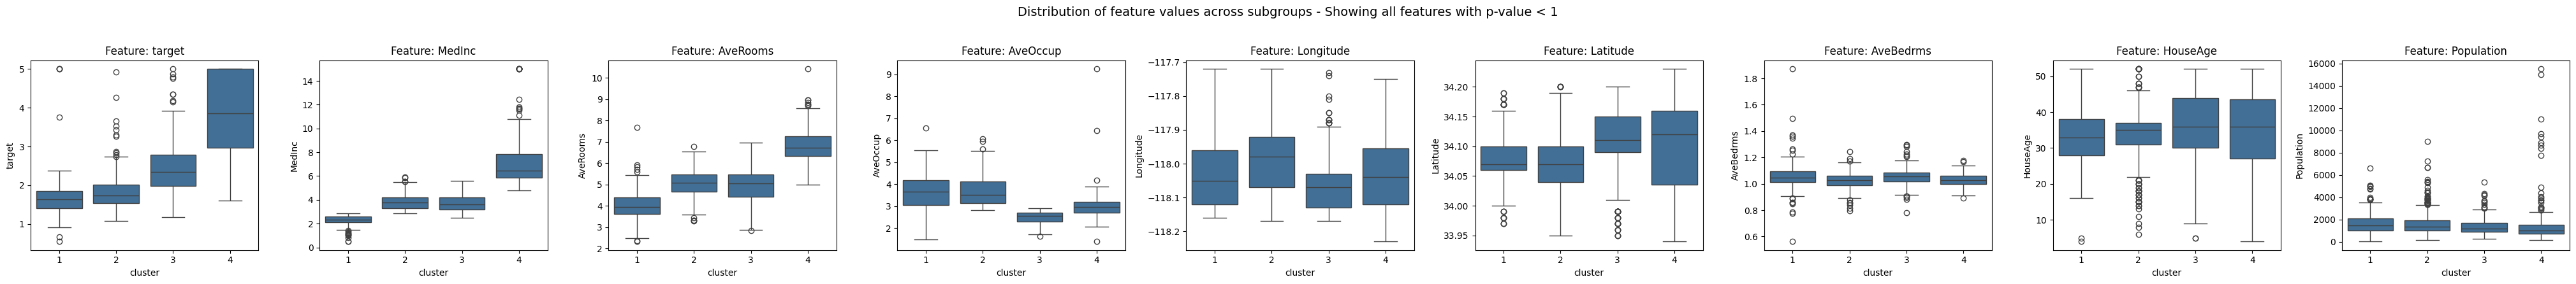

In [5]:
fgc = FgClustering(model=rf_housing, data=data_housing_test, target_column='MedHouseVal')
fgc.run(number_of_clusters=4) 

fgc.plot_decision_paths(heatmap=False, num_cols = 9)

Comparing the boxplots of FGC run on the training vs test data, we can see that we have communalities but also differences between both datasets. For instance, the feature *MedInc*, *AveRooms* and *AveOccup* show the same trend for the training and test set. On the other hand, features like *Latitude* and *Longitude* don't contribute as strongly to the distinction of the two cluster with the intermediate valued houses and also *House Age* shows no significant trend for any of the cluster. This might also explain why the model is performing worse on the test set. It likely picked up some patterns that are specific for the training set but can't be generalized.